# Flat Clustering (K-Means)
---

## Env Preparation

In [161]:
import os
import sys
os.chdir('/app/')
print(os.getcwd())
from os.path import join as JP
sys.path.append(os.getcwd())
sys.path.append(JP(os.getcwd(),'utils'))
sys.path.append(JP(os.getcwd(),'scripts'))

/app


In [162]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib notebook
np.set_printoptions(precision=3)
pd.options.display.float_format = '{:,.3f}'.format

In [163]:
import pickle
from pprint import pprint
from collections import defaultdict

from utils.nlp_utils import preproces
from utils.general import parse_yaml, ensure_directories

from scripts.catalog import (
    Catalog, Document, Corpus,
    load_catalog, load_corpus)

config = parse_yaml('config.yaml')
paths = config['paths']
ensure_directories(paths)

## Data

In [164]:
data = pd.read_csv(JP(paths['data'],'bbc-text-processed.csv')).iloc[:,1:]
data.head()

,category,text,lenght,processed
0,tech,tv future in the hands of viewers with home th...,806,tv future hand viewer system plasma high defin...
1,business,worldcom boss left books alone former worldc...,332,left book ebber accuse oversee 11bn fraud acco...
2,sport,tigers wary of farrell gamble leicester say ...,270,wary farrell gamble rush make bid decide switc...
3,sport,yeading face newcastle in fa cup premiership s...,390,yeade face premiership face trip leader yeade ...
4,entertainment,ocean s twelve raids box office ocean s twelve...,287,raid ocean crime go number office chart take w...


## TFIDF

In [165]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [166]:
EMBED_SIZE = 10000        # TODO: Increase
NUM_CLUSTERS = data['category'].nunique()
WORDS_PER_CLUSTER = None
print(NUM_CLUSTERS)

5


In [167]:
vectorizer = TfidfVectorizer(
    min_df=.05,
    max_df=.9,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_features=EMBED_SIZE,
    ngram_range=(1,3),
    lowercase=True,
    stop_words=stopwords.words('english'))

## Moving to a Catalog Format

In [168]:
documents = [Document() for i in range(data.shape[0])]
for d in range(len(documents)):
    documents[d].processed_text = data['processed'][d]

In [169]:
catalog = Catalog()
catalog.documents = documents

In [170]:
_ = catalog.collect_corpus(attr='processed_text', form=list)
tfidf = catalog.to_matrix(
    vectorizer=vectorizer,
    modelname='TFIDF',
    max_docs=None)
print(tfidf.representation.shape)
tfidf.representation.head()

(2225, 461)


,able,accept,access,accord,account,accuse,act,action,add,admit,...,week,weekend,win,winner,woman,work,world,write,year,young
0,0.000,0.000,0.000,0.037,0.000,0.000,0.000,0.000,0.027,0.000,...,0.000,0.000,0.000,0.000,0.000,0.029,0.000,0.000,0.038,0.000
1,0.000,0.000,0.000,0.000,0.000,0.150,0.000,0.000,0.000,0.299,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.239,0.066,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.115,0.000,0.000,0.000,0.000,0.000,0.000,...,0.093,0.315,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## Clustering

In [171]:
from sklearn.cluster import KMeans

def kmean_clustering(
    data:pd.DataFrame,
    num_clusters:int=4,
    njobs=-1,
    random_state=46):
    '''
    Perform K-Means Algorithm
    Args:
        - model: Trained instance of class Model
        - num_clusters: Number of Clusters to look for

    Returns: 
        - Clustering model instance
    '''
    km = KMeans(
        n_clusters=num_clusters,
        init='k-means++',
        n_init=20,
        max_iter=1000,
        n_jobs=njobs,
        random_state=random_state)
    return km.fit(data)

In [172]:
def words_per_cluster(
    model,
    clusters:KMeans,
    words_per_cluster:int=None):
    '''
    Return the j most important words per cluster
        The k closest to the centroid of that cluster
        Equivalently: the words are the ones most present in the 'fake'
        document represented by the centroid of the cluster

    Args:
        - Clustering model instance
    
    Returns:
        - Dict key='cluster id', value=k_words_closest_to_centroid
    '''
    
    cluster_words = defaultdict(list)
    centroids = clusters.cluster_centers_
    
    # For each centroid
    for i,centroid in enumerate(centroids):
        # Bring K most similar words to centroid i
        closests_words_to_centroid = centroid.argsort()[::-1] 
        for idx in closests_words_to_centroid:
            cluster_words[i].append(model.id2token[idx])
    return cluster_words

In [173]:
def get_centroids(
    model, #:Model
    clusters:KMeans):
    ''' Return the TFIDF representation of the centroids of a KMeans object '''
    centroids = pd.DataFrame(clusters.cluster_centers_, columns=model.representation.columns)
    centroids.index = range(1,clusters.cluster_centers_.shape[0]+1)
    return centroids

In [197]:
import umap
from sklearn.decomposition import PCA

In [239]:
MIN_K = 2
MAX_K = 10
words_results = defaultdict(lambda: defaultdict())
cluster_results = defaultdict(lambda: defaultdict())
embedding_results = defaultdict(lambda: defaultdict())

In [258]:
pca = PCA(n_components=50)
data_low_dim = pca.fit_transform(tfidf.representation.values)
data_low_dim_umap =  pd.DataFrame(
    umap.UMAP(
        n_neighbors=5, n_components=3, metric='cosine').fit_transform(tfidf.representation.values),
    columns=['d1','d2','d3'])

In [259]:
d = tfidf.representation
dlow = data_low_dim_umap.copy()
for k in range(MIN_K,MAX_K):    

    # Compute clsutering
    clusters = kmean_clustering(data_low_dim, njobs=-1, num_clusters=k)
    words = words_per_cluster(tfidf,clusters)
    
    # Compute centroids
    d['cluster'] = clusters.labels_
    dlow['cluster'] = clusters.labels_
    centroids = d.groupby('cluster').mean().reset_index()
    
    # Compute word importance
    scores = pd.melt(
        centroids, id_vars=['cluster'], var_name='word', value_name='score')
    
    # Store
    words_results[k] = scores
    words_results[k]['num_clusters'] = k   ## TODO: substitute this later for nunique()
    cluster_results[k] = clusters
    embedding_results[k] = dlow.copy()
    embedding_results[k]['num_clusters'] = k

In [260]:
def dict_of_dataframes_to_one_dataframe(input_dict:dict):
    ''' Convert a dict of dataframes into a single dataframe with a column for the keys '''
    d = pd.DataFrame()
    for k,df in input_dict.items():
        d = pd.concat([d,df])
    return d

In [261]:
words_results_df = dict_of_dataframes_to_one_dataframe(dict(words_results))
embedding_results_df = dict_of_dataframes_to_one_dataframe(dict(embedding_results))

In [262]:
# Sanity check
# words_results_df[words_results_df['num_clusters'] == 6]
# embedding_results_df[embedding_results_df['num_clusters'] == 7]['cluster'].unique()

In [263]:
name = 'words_per_cluster_{}_to_{}'.format(MIN_K,MAX_K)
with open(JP(paths['results'], name+'.pkl'), 'wb') as f:
    pickle.dump(dict(words_results), f)
words_results_df.to_csv(JP(paths['results'], name+'.csv'))

In [264]:
name = 'embeddings_per_cluster_{}_to_{}'.format(MIN_K,MAX_K)
with open(JP(paths['results'], name+'.pkl'), 'wb') as f:
    pickle.dump(dict(embedding_results), f)
embedding_results_df.to_csv(JP(paths['results'], name+'.csv'))

## Visualizing the clusters
---

In [266]:
fig = px.scatter_3d(embedding_results[3], x='d1', y='d2', z='d3', color='cluster')
fig.update_traces(marker=dict(size=3))
fig.show()

## Plotting the WordClouds
---

In [183]:
%matplotlib inline
from wordcloud import WordCloud

#### Helper Functions for Plotting

In [184]:
def define_subplots(n_cols,n_plots,figsize=None):
    '''Return the axes given a total 
    of plots and desired number of columns'''
    j = 1 if n_plots%n_cols != 0 else 0
    n_rows = (n_plots // n_cols) + j 
    
    if not figsize: 
        figsize=(n_cols*5,n_rows*5)
    
    fig, axs = plt.subplots(
        nrows=n_rows, ncols=n_cols, sharex=False, sharey=False,
        figsize=figsize)
    
    return fig,axs

In [185]:
def cluster_to_wordcloud(
    df, max_words=200, use_mask=False, bgcolor='black'):
    ''' Convert 1 cluster into a WordCloud given:
        - The TFIDF for the cluster
        - The Score Method that give imporance to the word '''
    # Create the wordcloud attending to the inverse of idf
    wordcloud = WordCloud(
        max_words=max_words, 
        mask=mask_ if use_mask else None,
        background_color=bgcolor).generate_from_frequencies(
            frequencies=dict(zip(df.word, df.score)))
    return wordcloud


In [186]:
def plot_centroids_as_wordclouds(
    word_scores,
    NUM_CLUSTERS = None,
    max_words_per_cloud=100, 
    use_mask=False, n_cols=2, figsize=(15,15)):

    if not NUM_CLUSTERS:
        NUM_CLUSTERS = word_scores.cluster.nunique()

    n_plots = NUM_CLUSTERS
    _, axs = define_subplots(n_cols,n_plots, figsize)
    
    for c in range(NUM_CLUSTERS):
        wordcloud = cluster_to_wordcloud(
            df=word_scores[word_scores.cluster == c],
            max_words=max_words_per_cloud,
            use_mask=use_mask)
        
        # Plot the resulting wordcloud
        if len(axs.shape) == 1:
            axs[c].imshow(wordcloud)
            axs[c].axis('off')            
        else:
            axs[c // n_cols, c % n_cols].imshow(wordcloud)
            axs[c // n_cols, c % n_cols].axis('off')
    plt.tight_layout()
    plt.show()
    return


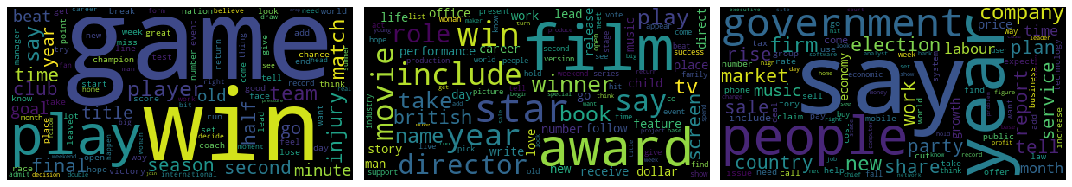

In [187]:
plot_centroids_as_wordclouds(words_results[3], n_cols=3)

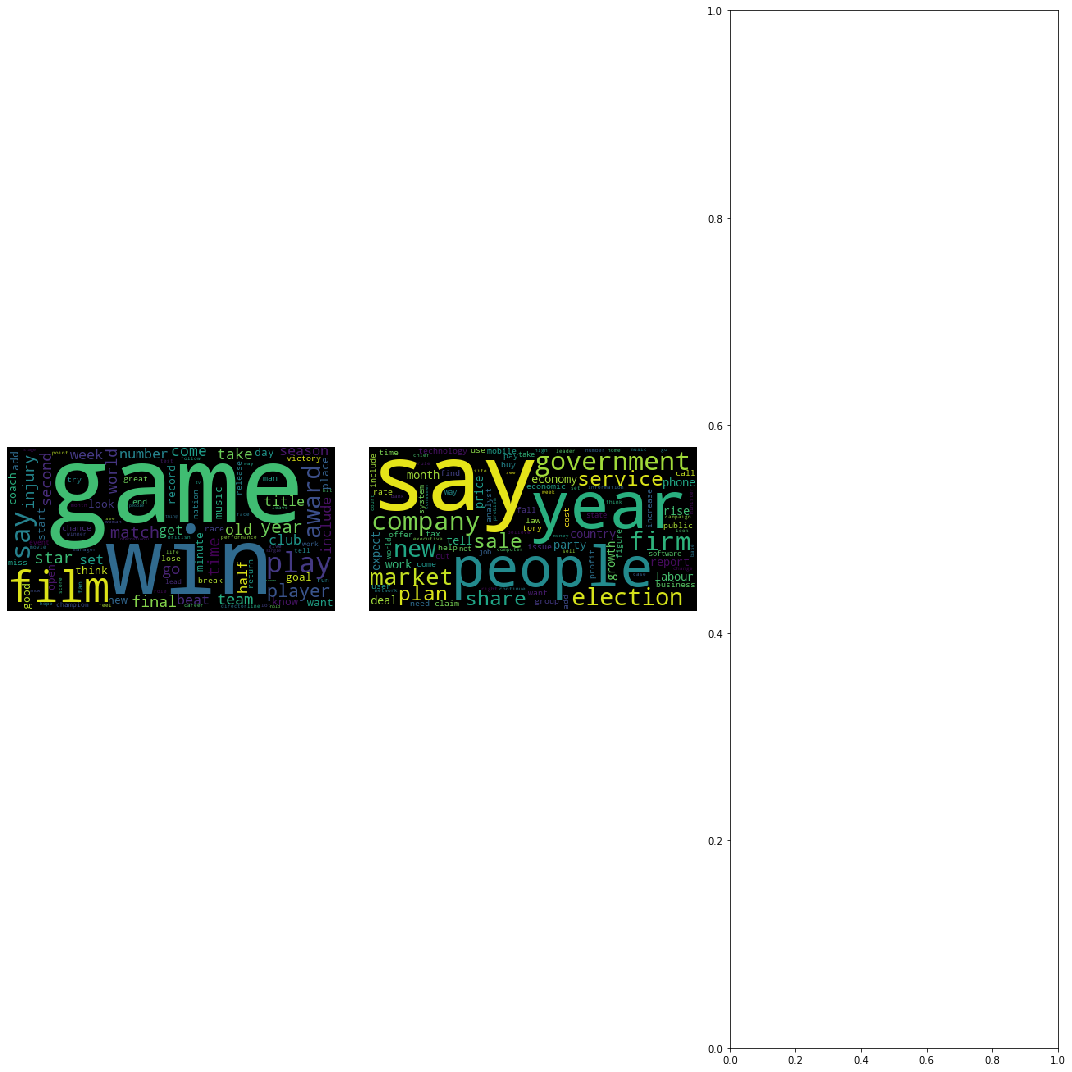

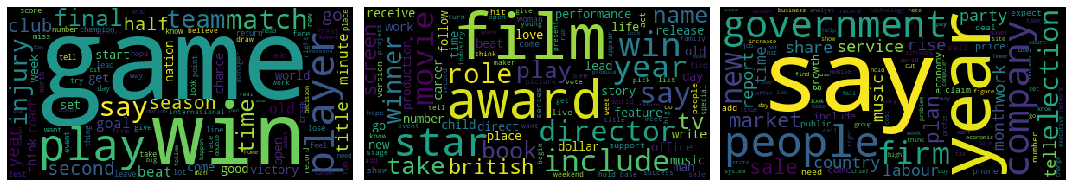

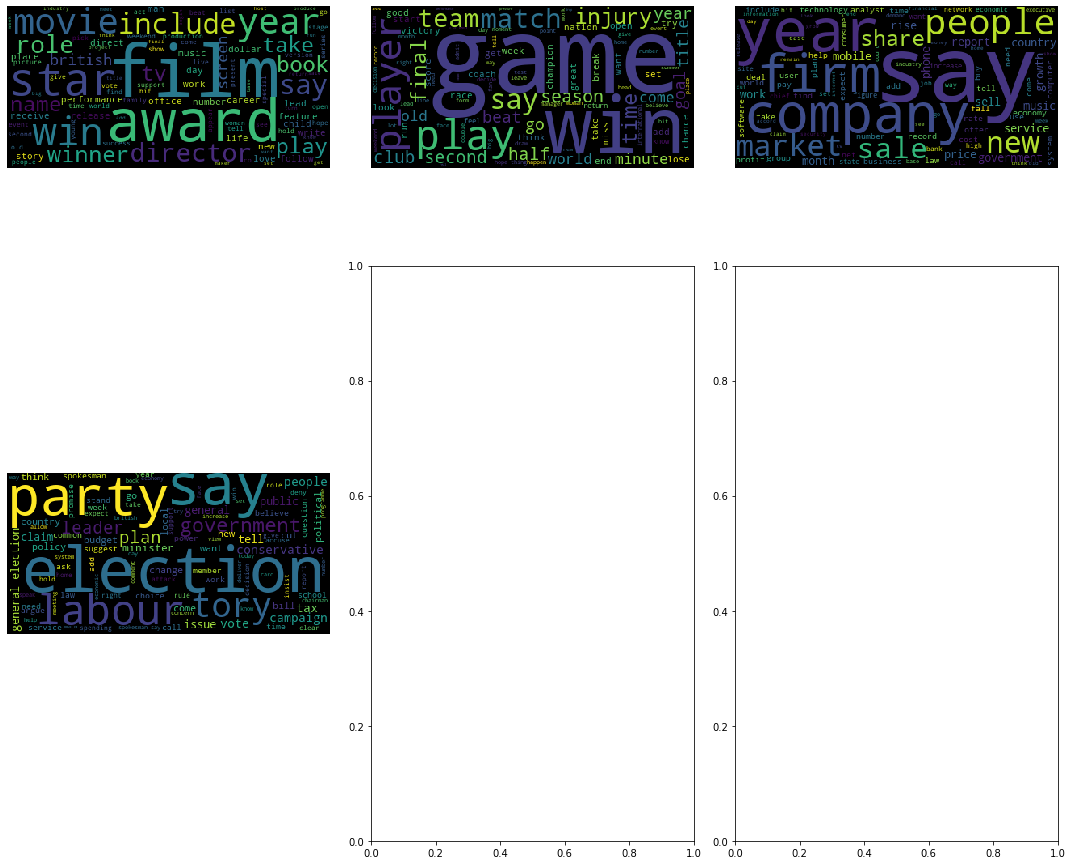

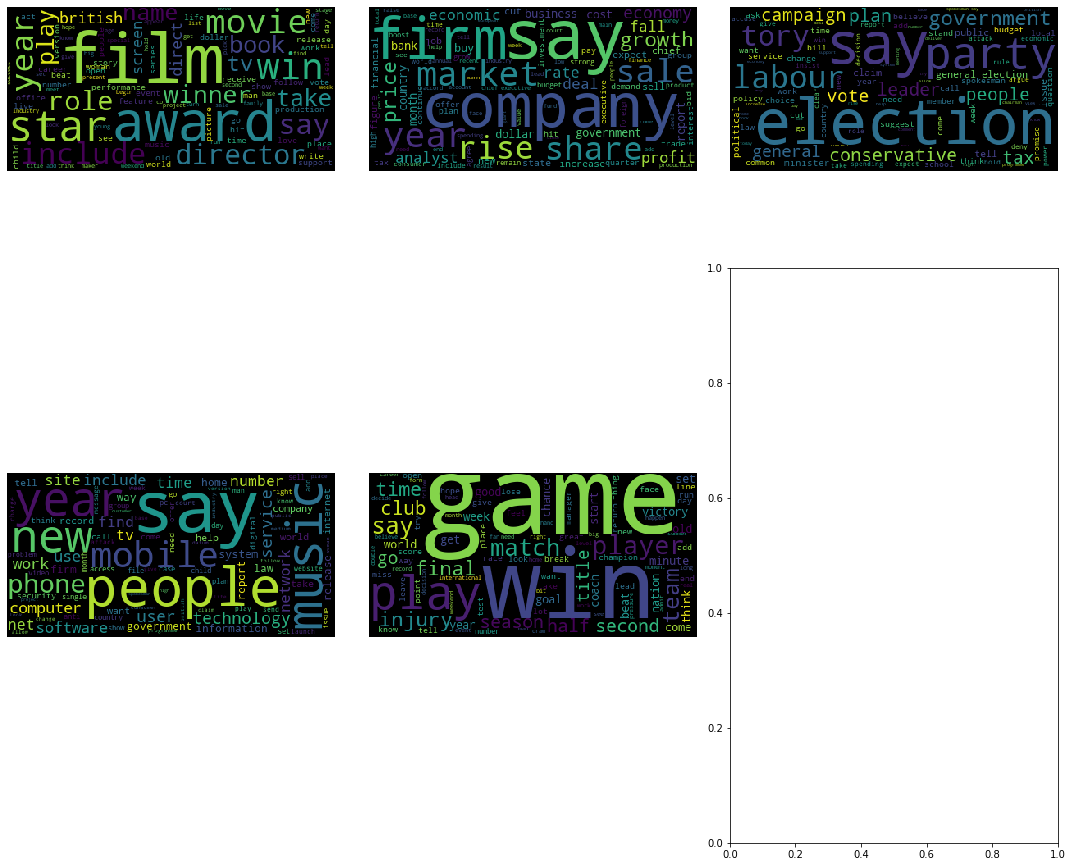

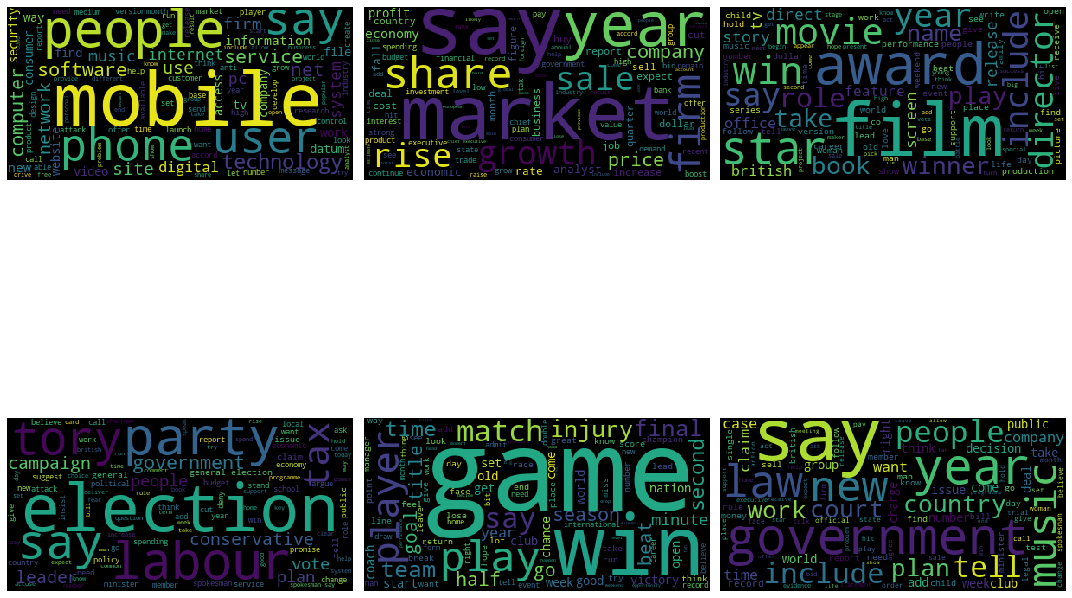

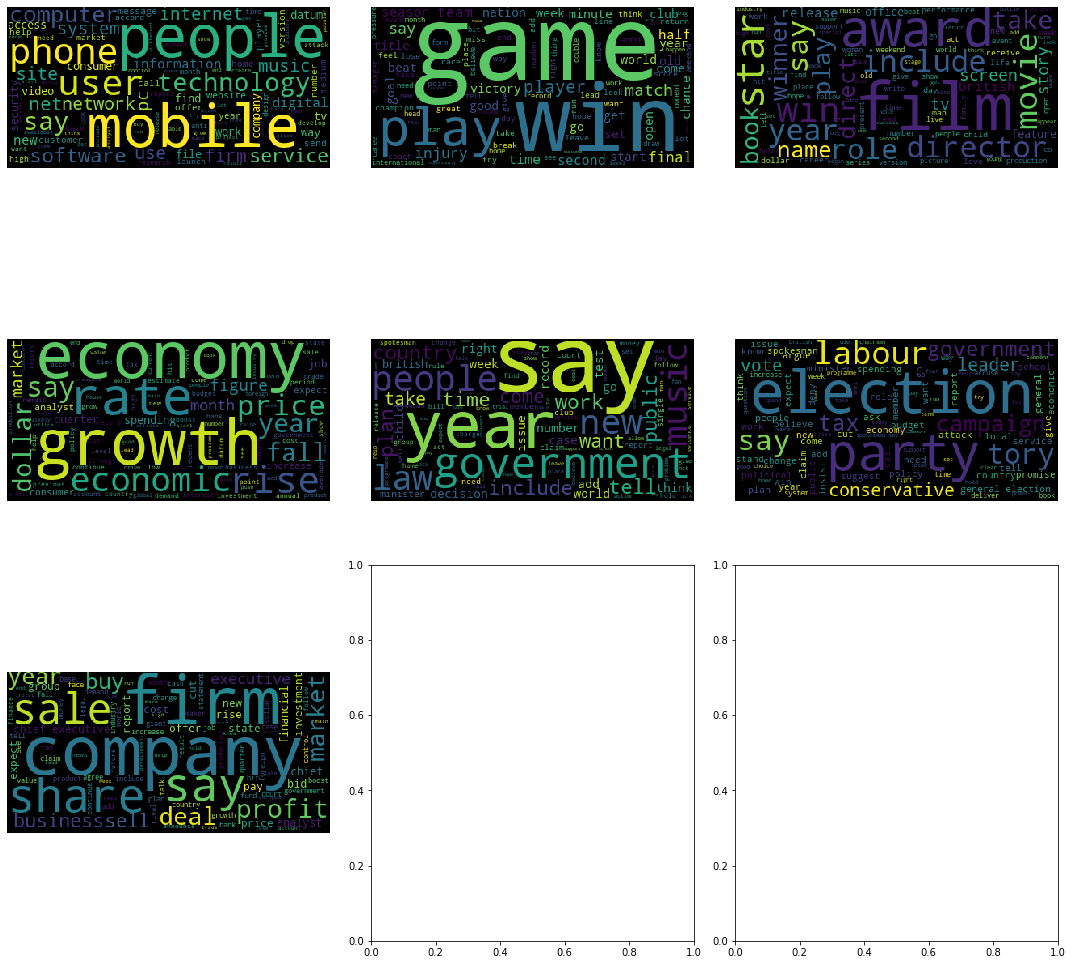

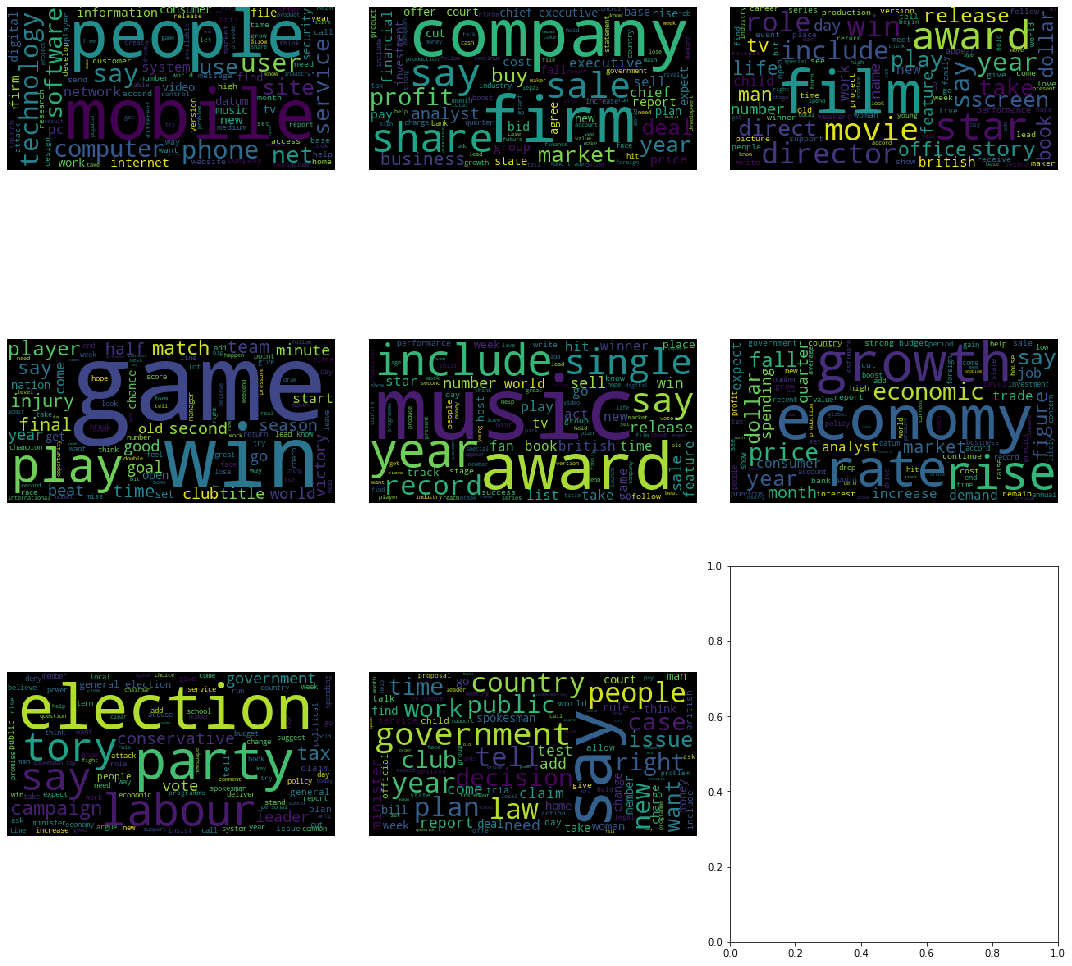

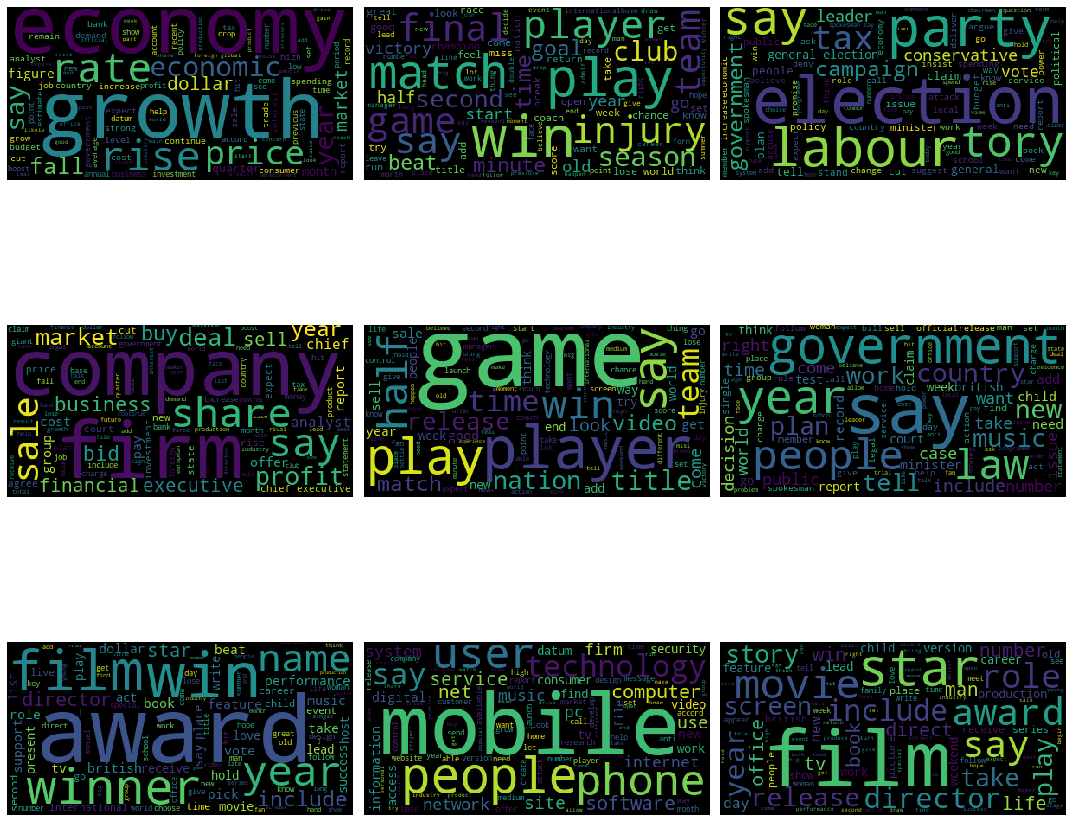

In [188]:
for k in range(MIN_K, MAX_K):
    plot_centroids_as_wordclouds(words_results[k], n_cols=3)